# **Causal Modeling**

*Author: Maarten Vonk and Ninoslav Malekovic*

This is the script containing the Causal Model for the project, for which the findings have been presented in the paper. It contains several parts:

1.   Install and import relevant modules and packages: All the python and R related packages will be installed in this chapter. Because some of the causal models rely heavily on modules avilable in R, substantial time is required to install and import all these packages. When same installations are followed, one is able to replcate the results in the notebook by executing the cells.
2.   Data Preprocessing: in this chapter we deal with objects types and probematic column names, include new features based on range and manage missing data.
3.   Causal Modeling Instantation: the causal model is defined in a class function along with its parameters for the instantiation of the causal model. Choices made are accompanied by comments and docstrings together with references to papers. Two causal discovery methods are used and their results are shown.  
4.   Causal Modeling Collection of Results: this chapter merely serves to extract all the necessary and relevant data, which are the causal graphs, the causal estimates and the latent causal estimates.

In essence, the notebook aggregates the data with the relevant methods and develops the causal graphs when assuming causal sufficicency and when letting go of causal sufficiency assumption (DAG and ADMG respectively). The notebook is accompanied by clarification comments and references to the papers for which algorithms have been adopted.

## **Imports**

In [1]:
#!pip install pandas==1.1.5 &> /dev/nul
#!pip install tables==3.5.1 &> /dev/nul
!pip install cdt &> /dev/nul
!sudo apt install graphviz libgraphviz-dev graphviz-dev pkg-config &> /dev/nul
!pip install pygraphviz &> /dev/nul
!pip install pydot &> /dev/nul
!pip install pyparsing==1.5.7 &> /dev/nul
!pip install GML &> /dev/nul
!pip install unidecode &> /dev/nul
!pip install dowhy==0.9.1 &> /dev/nul
!pip install statsmodels &> /dev/nul
!pip install pickle-mixin &> /dev/nul
!pip install pyyaml==5.4.1 &> /dev/nul
#!pip install ananke-causal &> /dev/nul
#!pip install -U javabridge &> /dev/nul
!pip install git+https://github.com/bd2kccd/py-causal &> /dev/nul
!pip install --force-reinstall numpy==1.22.1 &> /dev/nul
!pip install --force-reinstall rpy2==3.5.1 &> /dev/nul

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import tables
import numpy as np
import logging.config
import sys
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from patsy import dmatrices
import GPUtil
#import unidecode
#import joblib
#import torch
import tqdm
import requests
import difflib as dl
import sklearn
import cdt #CDT depends on a number of other packages, including these R packages: https://github.com/FenTechSolutions/CausalDiscoveryToolbox/blob/master/r_requirements.txt.
from cdt.causality.graph import GES
import networkx as nx
import dowhy
from dowhy import CausalModel
import statsmodels
import statsmodels.api
from IPython.display import Image, display
from google.colab import auth
from itertools import permutations
import pygraphviz
import pydot
import pydotplus
import pyparsing
import torch
import tqdm
from sklearn.preprocessing import MinMaxScaler
#import pycausal
from IPython.display import SVG
import statsmodels.api as sm
import statsmodels.formula.api as smf

Detecting 1 CUDA device(s).


In [3]:
gbase = importr('base')
utils = importr('utils')

utils.chooseCRANmirror(ind=1)
packnames_CRAN_direct = ('devtools', 'BiocManager', 'sparsebn', 'pcalg', 'gRain', 'bnlearn') #Alternatively, 'http://www.bnlearn.com/releases/bnlearn_latest.tar.gz'
names_to_install_CRAN_direct = [x for x in packnames_CRAN_direct if not rpackages.isinstalled(x)]
if len(names_to_install_CRAN_direct) > 0:
    utils.install_packages(StrVector(names_to_install_CRAN_direct))

biocmanager = importr('BiocManager')
packnames_biocmanager = ('graph', 'RBGL', 'Rgraphviz', 'gRain')
names_to_install_biocmanager = [x for x in packnames_biocmanager if not rpackages.isinstalled(x)]
if len(names_to_install_biocmanager) > 0:
    biocmanager.install(StrVector(names_to_install_biocmanager))

utils.install_packages('pcalg')
pcalg = importr('pcalg')
graph = importr('graph')
rbgl = importr('RBGL')
rgraphviz = importr('Rgraphviz')
bnlearn = importr('bnlearn')

(as ‘lib’ is unspecified)














































































































	‘/tmp/RtmphKAJts/downloaded_packages’

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org































	‘/tmp/RtmphKAJts/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/RtmphKAJts/downloaded_packages’



In [4]:
cdt.SETTINGS.GPU
cdt.SETTINGS.NJOBS
cdt.SETTINGS.NJOBS = 3
cdt.SETTINGS.verbose = False

In [5]:
print (dowhy.__version__)

0.9.1


## **Check Overlap over Timeframes**

In [7]:
# Import data locally
url1, url2, url3, url4, url5  = 'climate_1.csv', 'climate_2.csv', 'demographics.csv', 'agriculture.csv', 'conflicts.csv' #Aplied Data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root = "/content/drive/My Drive/Colab Notebooks/WPS2024/data/"
climate1 = pd.read_csv(root+url1, header = [0, 1, 2], index_col = [0, 1])
climate2 = pd.read_csv(root+url2, header = [0, 1, 2], index_col = [0, 1])
demographics = pd.read_csv(root+url3, header = [0, 1, 2], index_col = [0, 1])
crop_production = pd.read_csv(root+url4, header = [0, 1, 2], index_col = 0)
ACLED_complete = pd.read_csv(root+url5, header = [0, 1, 2], index_col = [0, 1])
#climate1_2 = pd.read_csv(root+url6, header = [0, 1, 2], index_col = [0, 1])

Mounted at /content/drive


In [8]:
#Add columns
crop_production['Year'] = '2020-01-01'
crop_production.set_index(['Year'], append=True, inplace=True)

## **Aggregating or Slicing of Data**

Either aggregate or slice the data

### **Aggregation**

In [9]:
useful_aggregations = ['count','max','mean','min','std','sum']
vars=['%s_cols'%(i) for i in useful_aggregations]
vars

['count_cols', 'max_cols', 'mean_cols', 'min_cols', 'std_cols', 'sum_cols']

In [10]:
#Copy the datasets, select the relevant timeframes and remove the triple column headers
ACLED_complete_copy = ACLED_complete.copy()
ACLED_complete_copy.columns = [' '.join(col).strip() for col in ACLED_complete_copy.columns.values]

idx = pd.IndexSlice
climate_1_start, climate_1_end = '2020-01-01', '2021-09-01'
climate_2_start, climate_2_end = '2020-01-01', '2021-09-01'
dem_start, dem_end = '2020-01-01', '2020-01-01'
cropprod_start, cropprod_end = '2020-01-01', '2021-01-01'
demographics = demographics.loc[idx[:,dem_start:dem_start],:].reset_index(level=1, drop=True)
demographics.columns = [' '.join(col).strip() for col in demographics.columns.values]

crop_production = crop_production.loc[idx[:,cropprod_start:cropprod_end],:].reset_index(level=1, drop=True)
crop_production.columns = [' '.join(col).strip() for col in crop_production.columns.values]

In [11]:
climate1_copy = climate1.copy()
climate1_copy.replace(9999, np.nan, inplace=True)
climate1_copy.replace(-9999, np.nan, inplace=True)
climate_1 = climate1.loc[idx[:,climate_1_start:climate_1_end],:].reset_index(level=1, drop=True)
climate1_copy.columns = [' '.join(col).strip() for col in climate1_copy.columns.values]

climate2_copy = climate2.copy()
climate_2 = climate2.loc[idx[:,climate_2_start:climate_2_end],:].reset_index(level=1, drop=True)
climate2_copy.columns = [' '.join(col).strip() for col in climate2_copy.columns.values]

In [12]:
useful_aggregations = ['max','min','sum','std'] # Considered aggregations
vars=['%s_cols'%(i) for i in useful_aggregations] # Variable name for all columns for different aggregations
d,e={},{}
for i in useful_aggregations:
    d['%s_cols'%(i)] = [x for x in climate1_copy.columns if i in x] # Get columns per aggregation for the dataset
    e['%s_cols'%(i)] = [x for x in climate2_copy.columns if i in x]
agg_methods11 = {**dict.fromkeys(d[vars[0]],useful_aggregations[0]), **dict.fromkeys(d[vars[1]],useful_aggregations[1]),**dict.fromkeys(d[vars[2]],useful_aggregations[2])}
agg_methods12 = {**dict.fromkeys(d[vars[0]],useful_aggregations[3]),**dict.fromkeys(d[vars[1]],useful_aggregations[3]), **dict.fromkeys(d[vars[2]],useful_aggregations[3])}
agg_methods21 = {**dict.fromkeys(e[vars[0]],useful_aggregations[0]), **dict.fromkeys(e[vars[1]],useful_aggregations[1]),**dict.fromkeys(e[vars[2]],useful_aggregations[2])}
agg_methods22 = {**dict.fromkeys(e[vars[0]],useful_aggregations[3]),**dict.fromkeys(e[vars[1]],useful_aggregations[3]), **dict.fromkeys(e[vars[2]],useful_aggregations[3])}

In [13]:
#Aggregations, max date is 2021-09-01
ACLED_complete_copy = ACLED_complete_copy.groupby(level = [0]).sum() # Summing of the Acled Variables

climate1_copy = pd.concat([climate1_copy.groupby(level = [0]).agg(agg_methods11),climate1_copy.groupby(level = [0]).agg(agg_methods12)], axis=1)
climate1_copy.columns = ["{}_{:02}".format(a_, b_) for a_, b_ in zip(agg_methods11.keys(), agg_methods11.values())] + ["{}_{:02}".format(a_, b_) for a_, b_ in zip(agg_methods12.keys(), agg_methods12.values())]

climate2_copy = pd.concat([climate2_copy.groupby(level = [0]).agg(agg_methods21),climate2_copy.groupby(level = [0]).agg(agg_methods22)], axis=1)
climate2_copy.columns = ["{}_{:02}".format(a_, b_) for a_, b_ in zip(agg_methods21.keys(), agg_methods21.values())] + ["{}_{:02}".format(a_, b_) for a_, b_ in zip(agg_methods22.keys(), agg_methods22.values())]

In [14]:
df = pd.concat([climate1_copy, climate2_copy, demographics, crop_production, ACLED_complete_copy], axis=1)

### **Slicing (for Seasonality)**

In [ ]:
climate_1_start, climate_1_end = '2020-11-01', '2020-11-01'
climate_2_start, climate_2_end = '2020-11-01', '2020-11-01'
dem_start, dem_end = '2020-01-01', '2020-01-01'
cropprod_start, cropprod_end = '2020-01-01', '2020-01-01'
acled_date = '2020-11-01' #ACLED dates are not pd_datetime hence cannot accept slice

In [ ]:
import plotly.express as px
from datetime import datetime
df = pd.DataFrame([
    dict(Task="Climate 1 Data", Start=datetime.strptime(climate_1_start, '%Y-%m-%d').date(), Finish=datetime.strptime(climate_1_end, '%Y-%m-%d').date()+ pd.DateOffset(months=1)),
    dict(Task="Climate 2 Data", Start=datetime.strptime(climate_2_start, '%Y-%m-%d').date(), Finish=datetime.strptime(climate_2_end, '%Y-%m-%d').date()+ pd.DateOffset(months=1)),
    dict(Task="Demographics Data", Start=datetime.strptime(dem_start, '%Y-%m-%d').date(), Finish=datetime.strptime(dem_end, '%Y-%m-%d').date()+ pd.DateOffset(months=1)),
    dict(Task="Crop Production Data", Start=datetime.strptime(cropprod_start, '%Y-%m-%d').date(), Finish=datetime.strptime(cropprod_end, '%Y-%m-%d').date()+ pd.DateOffset(months=1)),
    dict(Task="ACLED Data", Start=datetime.strptime(acled_date, '%Y-%m-%d').date(), Finish=datetime.strptime(acled_date, '%Y-%m-%d').date()+ pd.DateOffset(months=1)),
])

fig = px.timeline(df, x_start="Start", x_end="Finish", y="Task")
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

In [ ]:
idx = pd.IndexSlice
climate_1 = climate1.loc[idx[:,climate_1_start:climate_1_end],:].reset_index(level=1, drop=True)
climate_2 = climate2.loc[idx[:,climate_2_start:climate_2_end],:].reset_index(level=1, drop=True)
demographics = demographics.loc[idx[:,dem_start:dem_start],:].reset_index(level=1, drop=True)
crop_production = crop_production.loc[idx[:,cropprod_start:cropprod_end],:].reset_index(level=1, drop=True)
ACLED_complete = ACLED_complete.loc[idx[:,acled_date],:].reset_index(level=1, drop=True)

In [ ]:
df = pd.concat([climate_1, climate_2, demographics, crop_production, ACLED_complete], axis=1)
df.columns = [' '.join(col).strip() for col in df.columns.values] # collapse column names

## **Prepare non-reduced data**

In [15]:
class Prepare_Data:
    """
    Class function to preprocess the data that one can then use for causal modeling. Imports the raw data and exports data that
    immediatly fits causal model arguments.
    Attributes:
        change_object_type (pd.Dataframe): replace data and change object type to numeric
        deal_with_string_column_names (pd.Dataframe): eliminate problematic string data
        include_range_data (pd.Dataframe): add new features based on min-max range
        deal_with_missing_data (pd.Dataframe): removes or replaces nans
    """

    def __init__(self, data):
        """
        Initiate data and logger
        :data (pd.Dataframe) : to be converted data
        """
            # Create logger
        log_format = '%(asctime)s - %(name)s - %(levelname)s - %(funcName)s - %(message)s'
        logging.basicConfig(format=log_format, level=logging.INFO, stream=sys.stdout)
        logger = logging.getLogger()
        self.data = data
        self.logger = logging.getLogger(__name__)

    def prepare_data(self):
        """
        This functions continuously plays all the pre processing activities for causal modeling.
        :return (pd.Dataframe): preprocessed data
        """
        self.logger.info("start preprocessing data")

        # Change the object types
        self.change_object_type()
        # Deal with awkward column string names
        self.deal_with_string_column_names()
        # Deal with missing data
        self.deal_with_missing_data()

        return self.data

    def change_object_type(self):
        """
        Since all the data are floats, we convert the data type.
        :return (pd.Dataframe): preprocessed data
        """

        self.logger.info("start initiating data")
        data = self.data

        # Eliminate all rows where there is no data present
        data.replace(['--'], [np.nan], inplace=True)  # replace -- by np.nan
        data.loc[:, data.columns != 'ADM3_EN'] = data.loc[:, data.columns != 'ADM3_EN'].apply(pd.to_numeric, errors='raise')
        self.data=data

    def deal_with_string_column_names(self):
        """
        This functions adjusts column names by removing problemetic string combinations.
        :return (pd.Dataframe): preprocessed data
        """

        self.logger.info("deal with missing data")
        data = self.data

        # #Strip symbols from column names for efficient column selection
        data.columns = data.columns.str.replace("","")
        data.columns = data.columns.str.replace("''","")
        data.columns = data.columns.str.replace("(","")
        data.columns = data.columns.str.replace(")","")
        data.columns = data.columns.str.replace(" ","_")

        self.data = data


    def deal_with_missing_data(self):
        """
        This functions deals with missing data and replaces it with the mean.
        :return (pd.Dataframe): preprocessed data
        """

        self.logger.info("deal with missing data")
        data = self.data

        #Replace inf by NaN values
        data.replace([np.inf, -np.inf], np.nan, inplace=True)

        #Drop NaN values instead of fill
        data.dropna(how='all',axis=1, inplace=True) # Columns with > 16% missing values are dropped, together with 4 districts that have many missing values
        data.fillna(data.mean(), inplace=True) # After considerations of missing at random or missing not at random, the most approriate data imputation seems mean. https://www.ncbi.nlm.nih.gov/books/NBK493614/
        self.data = data

In [16]:
pre_processing = Prepare_Data(df)
prepared_data = pre_processing.prepare_data()

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


### **Compute Overdispersion**

In [18]:
#Check overdispersion for the outcome variable total conflict events by manually computing mean and variance: https://s3.amazonaws.com/assets.datacamp.com/production/course_15356/slides/chapter3.pdf
prepared_data['ACLED_events_total']

municipalities
Abi Gharaq     4
Abu Dalf      18
Abu Ghraib    96
Agjalare       4
Akaika        49
              ..
Wasit          1
Yaijy         88
Yathreb       79
Zawita         5
Zummar        10
Name: ACLED_events_total, Length: 294, dtype: int64

In [19]:
y_mean = prepared_data['ACLED_events_total'].mean()
y_variance = prepared_data['ACLED_events_total'].var()
print(y_mean, y_variance)

70.48299319727892 39029.84100670984


## **Instantiation Causal Model**

In [20]:
class StaticCausalModel:
  """
  Class function that contains relevant causal model objects as attributes.
  Attributes:
      networkx_graph (networkx.Digraph): Extract causal DAG with GLASSO - GES combination
      create_PAG (tetrad object): Extract causal PAG without causal sufficiency or faithfulness assumption
      PAG2ADMG (ananke ADMG object): convert the extracted PAG two ADMG
      extract_causal_graph (DoWhy Causal Model object): convert DAG to DoWhy causal model
      return_directed_paths (list): list all the combinations of nodes for which there exist a causal path
      return_paths (pd.Dataframe): list all the combinations of nodes for which there exist a causal path
      view_ADMG (): draw the ADMG
      view_graph (): draw the DAG
      identification (identified object DoWhy): identify causal effect in the DAG
      latent_identification (identified object Ananke): identify causal effect in the ADMG
      estimation (float, float str): estimate causal effects in the DAG and return the causal effect, standard error and p-value
      latent_estimation (float, float float): estimate causal effects in the ADMG and returns causal effect, lower quantile and upper quantile.
  """
  # Note this class function mixes cdt functions to extract the causal graph with dowhy functions to identify, estimate and refute the causal effect.
  def __init__(self, data_to_graph, feature_selection, treatment, outcome):
    """
    Initiate arguments and logger
    :param features (list) : list of the used columns
    :param data (pd.Dataframe) : data
    :param treatment (str) : considered treatment in causal model
    :param outcome (str) : considered outcome in causal model
    """
    self.features = feature_selection
    self.data = data_to_graph[self.features]
    self.Glasso = cdt.independence.graph.Glasso()
    self.ges = cdt.causality.graph.GES()
    self.treatment = treatment
    self.outcome = outcome

  def networkx_graph(self):
    """
    Uses GLASSO to obtain the skeleton which is used as argument obtaining the causal graph with GES when causal sufficiency is assumed.
      Ref : Friedman, J., Hastie, T., & Tibshirani, R. (2008). Sparse inverse covariance estimation with the graphical lasso. Biostatistics, 9(3), 432-441.
      Ref: D.M. Chickering (2002). Optimal structure identification with greedy search. Journal of Machine Learning Research 3 , 507–554
    :return (networkx.Digraph): Extracted causal DAG with causal sufficiency
    """
    skeleton = self.Glasso.predict(self.data, alpha=1)
    return self.ges.predict(self.data, skeleton)

  def scale_data(self):
    non_predictive_columns = ['ACLED_fatalities_total','ACLED_fatalities_Violence_against_civilians','ACLED_events_total']
    predictive_variables = self.data.loc[:, ~self.data.columns.isin(non_predictive_columns)]
    transformer = MinMaxScaler().fit(predictive_variables)
    scaled_data = pd.DataFrame(transformer.transform(predictive_variables), columns = predictive_variables.columns)
    non_predictive_data = causal_data.loc[:, causal_data.columns.isin(non_predictive_columns)].reset_index()
    prepared_data = pd.concat([scaled_data, non_predictive_data], axis = 1)
    return prepared_data

  def extract_causal_graph(self):
    """
    Convert DAG to DoWhy causal graph object. Remove problematic arrows (verify removal by latent estimates).
    :return (dowhy Causal Model object): Extracted ADMG form PAG using bruteforce method
    """
    output_graph = StaticCausalModel.networkx_graph(self)
    nx.write_gml(output_graph, "G.gml")
    # CausalModel is a dowhy function to initiate the model based on the extracted causal graph.
    return CausalModel(data = StaticCausalModel.scale_data(self), treatment=self.treatment, outcome=self.outcome, graph= 'G.gml') # Note this is the model input required by dowhy

  def return_directed_paths(self):
    """
    Return the combinations of nodes for which there exist a directed path in the causal graph.
    :return (list): List of combinations of nodes.
    """
    DAG = StaticCausalModel.networkx_graph(self)
    combinations = list(permutations(DAG.nodes(), 2))
    return [combination  for combination in combinations if nx.has_path(DAG ,combination[0], combination[1])]

  def return_paths(self, start, end):
    """
    Return the directed paths based on start and end node.
    :start (str): startnode
    :node (str): endnode
    :return (list): List of causal paths
    """
    DAG = StaticCausalModel.networkx_graph(self)
    return [path for path in nx.all_simple_paths(DAG ,start, end)]

  def view_graph(self):
    """
    View DAG
    :return (DAG): Drawn DAG
    """
    return StaticCausalModel.extract_causal_graph(self).view_model(layout="dot")

  def identification(self):
    """
    Identify Causal Effect (if exists) in the DAG
    :return (identified object): a probability expression (estimand) for the causal effect if identified, else NULL
    """
    return StaticCausalModel.extract_causal_graph(self).identify_effect()

  def compute_alpha(self):
    """
    The estimated alpha to be used in the negative binomial causal effect computation (method extracted from https://timeseriesreasoning.com/contents/negative-binomial-regression-model/)
    :return (float): alpha
    """
    np.random.seed(45)
    #Separate training from test set
    mask = np.random.rand(len(self.data)) < 0.8
    df_train, df_test = self.data[mask], self.data[~mask]

    #Creating expression
    expr = self.outcome + " ~ "
    predictors = [x for x in self.features if x != self.outcome]
    expr += " + ".join(predictors)

    #Fit model
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    df_train['BB_LAMBDA'] = poisson_training_results.mu

    #Fit Poisson model
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

    #Fit model for alpha
    df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x[self.outcome] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
    ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
    aux_olsr_results = smf.ols(ols_expr, df_train).fit()
    return aux_olsr_results.params.values[0]

  def estimation(self):
    """
    The estimated causal effect based on generalized linear model and given method parameters.
    :return (float): causal effect
    :return (float): standard error
    :return (str): p-value
    """
    method_params = {'num_null_simulations':50, 'method': 'bootstrap', 'num_simulations':50,
                 'need_conditional_estimates': False, 'fit_method': "statsmodels", 'glm_family':statsmodels.api.families.NegativeBinomial(alpha=StaticCausalModel.compute_alpha(self))}
    #Dowhy function estimate_effect to estimate effect. Note we use generalized linear model with method_params defined with the causal models params.
    glm_estimate = StaticCausalModel.extract_causal_graph(self).estimate_effect(identified_estimand = StaticCausalModel.identification(self), method_name="backdoor.generalized_linear_model",
                                                                                test_significance=True, confidence_intervals = True, method_params = method_params)
    return glm_estimate, glm_estimate.get_standard_error(method = "bootstrap"), glm_estimate.test_stat_significance(method = "bootstrap").get('p_value')


GES is ran on the skeleton of the given graph.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


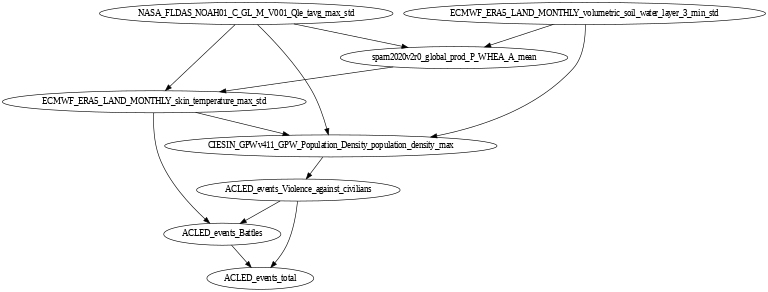

In [21]:
features = ['ACLED_events_total', 'ACLED_events_Violence_against_civilians', 'ACLED_events_Battles',
            'CIESIN_GPWv411_GPW_Population_Density_population_density_max',
            'NASA_FLDAS_NOAH01_C_GL_M_V001_Qle_tavg_max_std',
            'ECMWF_ERA5_LAND_MONTHLY_skin_temperature_max_std',
             'ECMWF_ERA5_LAND_MONTHLY_volumetric_soil_water_layer_3_min_std',
            'spam2020v2r0_global_prod_P_WHEA_A_mean'
]


feature_selection = features

#Static causal model takes treatment and outcome as arguments:
treatment = 'CIESIN_GPWv411_GPW_Population_Density_population_density_max'
outcome = 'ACLED_events_total'

causal_data = prepared_data.copy()

#'NASA_FLDAS_NOAH01_C_GL_M_V001_SoilMoi00_10cm_tavg_max_std'

#causal_data.rename(columns=renaming_dict, inplace=True)

# Initiate Causal Model an view causal graph
causal_model = StaticCausalModel(causal_data, feature_selection, treatment, outcome)
causal_model.view_graph()
display(Image(filename="causal_model.png"))